# ДЗ 1 по курсу Продвинутое глубокое обучение и обучение с подкреплением  
выполнил Денисов Артем MADE ML-32 

In [92]:
# pip install gym

In [1]:
from random import shuffle

import gym
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.blackjack import cmp, draw_card, deck, draw_hand, usable_ace, sum_hand, is_bust, score, is_natural

import numpy as np

import matplotlib.pyplot as plt

In [2]:
gym.__version__

'0.26.2'

## Часть первая с Блэкджеком и стратегиями

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
env = gym.make('Blackjack-v1', natural=True)

In [4]:
def easy_strategy(state, m):
    return state[0] < m

def experiments(easy_strategy, n=10000, m=19, verbose=False):
    rewards = []
    for i in range(n):
        observation, _ = env.reset()
        done = False
        reward = 0
        while not done:
            action = easy_strategy(observation, m)
            observation, reward, done, _, _ = env.step(action)
            if verbose:
                print(f"{i}, action {action}, observation {observation}, done {done}, reward {reward}")
        rewards.append(reward)
    return rewards

Чуть-чуть модифицирую самую простую стратегию, чтобы stand срабатывал не с 19 очоков и выше, а с числа из диапазона (10, 20)

In [5]:
for m in range(10, 21):
    n = 100000
    rewards = experiments(easy_strategy, n, m)
    print(f'Средний проигрыш при стратегии остановки после {m} за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при стратегии остановки после 10 за 100000 экспериментов: -0.16519
Средний проигрыш при стратегии остановки после 11 за 100000 экспериментов: -0.13315
Средний проигрыш при стратегии остановки после 12 за 100000 экспериментов: -0.10909
Средний проигрыш при стратегии остановки после 13 за 100000 экспериментов: -0.08986
Средний проигрыш при стратегии остановки после 14 за 100000 экспериментов: -0.07746
Средний проигрыш при стратегии остановки после 15 за 100000 экспериментов: -0.07336
Средний проигрыш при стратегии остановки после 16 за 100000 экспериментов: -0.0736
Средний проигрыш при стратегии остановки после 17 за 100000 экспериментов: -0.07849
Средний проигрыш при стратегии остановки после 18 за 100000 экспериментов: -0.10647
Средний проигрыш при стратегии остановки после 19 за 100000 экспериментов: -0.19747
Средний проигрыш при стратегии остановки после 20 за 100000 экспериментов: -0.35204


stand только после 19 оказалась не самой хорошей стратегией, останавливаться на 14-16 точно лучше, без каких-либо усложнений стратегии

In [6]:
m = 19
rewards = experiments(easy_strategy, n, m)
cummulative_profit = [sum(rewards[:i])/(i+1) for i in range(n)]

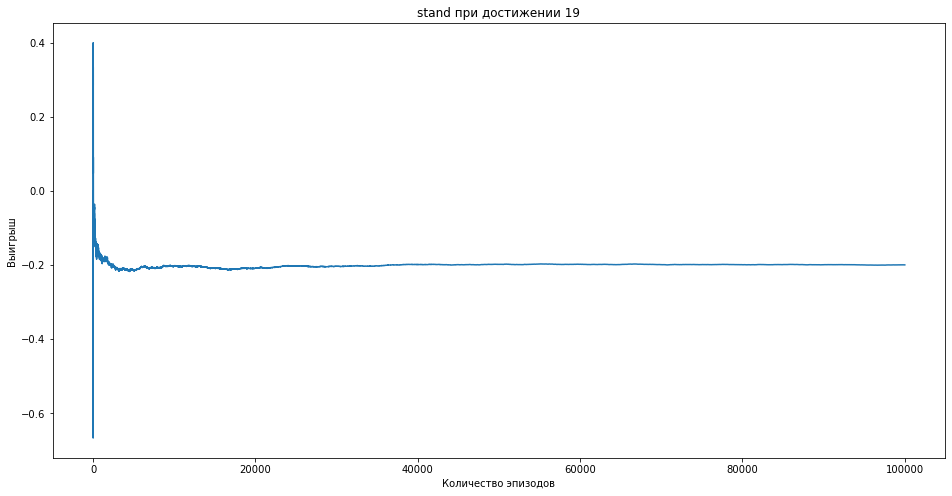

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(cummulative_profit)
plt.title(f'stand при достижении {m}')
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.show()

In [8]:
m = 16
rewards = experiments(easy_strategy, n, m)
cummulative_profit = [sum(rewards[:i])/(i+1) for i in range(n)]

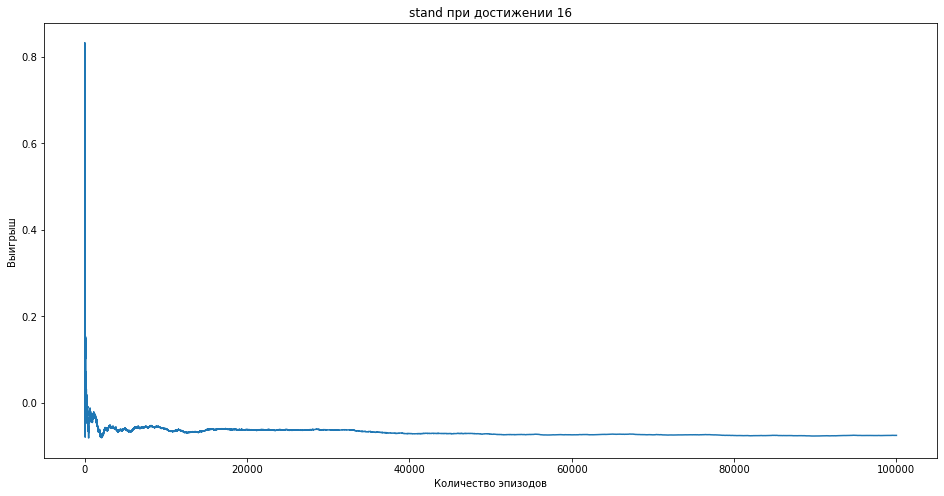

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(cummulative_profit)
plt.title(f'stand при достижении {m}')
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.show()

In [14]:
def learning_step(Q_function, alpha, epsilon, gamma):
    observation, _ = env.reset()
    pi = Q_function[observation]  
    if np.random.rand() > epsilon:
        action = max(pi, key=pi.get)
    else:
        action = np.random.randint(2)
    done = False
    while not done:
        observation_next, reward, done, _, _ = env.step(action)
        if np.random.rand() > epsilon:
            pi = Q_function[observation_next]  
            action_next = max(pi, key=pi.get)
        else:
            action_next = np.random.randint(2)
        Q_function[observation][action] += alpha * (reward + gamma * max(Q_function[observation_next].values()) - Q_function[observation][action])
        observation = observation_next
        action = action_next
    return Q_function

def learning(alpha=3e-4, epsilon=0.4, gamma=1.0, n_episodes=100000):
        function_Q = {(ph, dh, pa): {0: 0, 1:0} for ph in range(1, 32) for dh in range(1, 11) for pa in [True, False] for a in range(2)}
        for i in range(n_episodes):
            function_Q = learning_step(function_Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        return function_Q

def gambling(Q_function, n=10000):
        rewards = []
        for _ in range(n):
            observation, _ = env.reset()
            done = False
            reward = 0
            while not done:
                a = max(Q_function[observation], key=Q_function[observation].get)
                observation, reward, done, _, _ = env.step(a)
            rewards.append(reward)
        return rewards

In [15]:
Q_function = learning(alpha=3e-4, epsilon=0.4, gamma=1.0, n_episodes=100000)
rewards = gambling(Q_function, n=100000)
print(f'Средний проигрыш при Q-обучении за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при Q-обучении за 100000 экспериментов: -0.06064


получилось даже лучше, чем при наивной стратегии. Как минимум, здесь учитывается, что пасовать можно с разной сумме в руке, в зависимости от карт у дилера

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения.

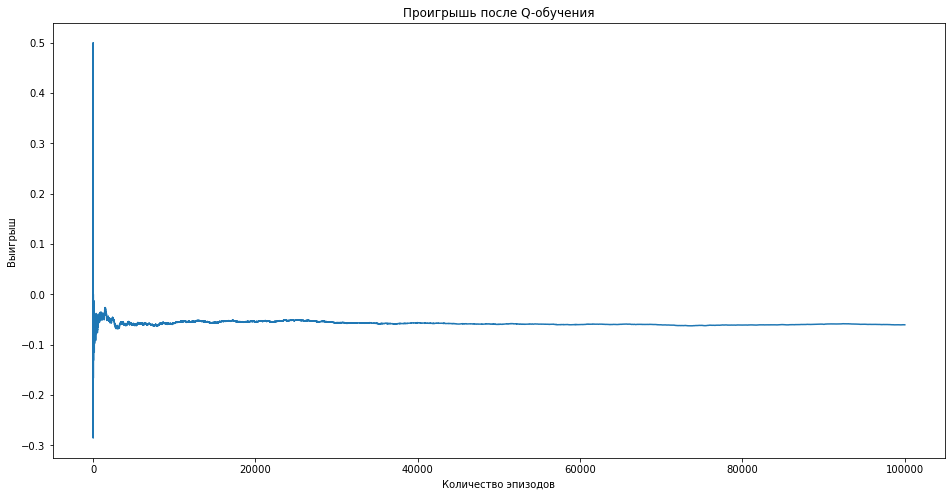

In [16]:
cummulative_profit = [sum(rewards[:i])/(i+1) for i in range(n)]
plt.figure(figsize=(16, 8))
plt.plot(cummulative_profit)
plt.title(f'Проигрышь после Q-обучения')
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.show()

Попробуйте подобрать оптимальные гиперпараметры.

In [18]:
grid_results = []
for alpha in [0.001, 0.0005, 0.0001]:
    for epsilon in [0.4, 0.5, 0.6]:
        Q_function = learning(alpha, epsilon, gamma=1, n_episodes=10000)
        rewards = gambling(Q_function, n=10000)
        grid_results.append([alpha, epsilon, np.mean(rewards)])
        print(f'Средний проигрыш при Q-обучении при {alpha}, {epsilon}: {np.mean(rewards)}')

Средний проигрыш при Q-обучении при 0.001, 0.4: -0.0838
Средний проигрыш при Q-обучении при 0.001, 0.5: -0.0601
Средний проигрыш при Q-обучении при 0.001, 0.6: -0.0668
Средний проигрыш при Q-обучении при 0.0005, 0.4: -0.0866
Средний проигрыш при Q-обучении при 0.0005, 0.5: -0.0757
Средний проигрыш при Q-обучении при 0.0005, 0.6: -0.0632
Средний проигрыш при Q-обучении при 0.0001, 0.4: -0.0715
Средний проигрыш при Q-обучении при 0.0001, 0.5: -0.0706
Средний проигрыш при Q-обучении при 0.0001, 0.6: -0.0759


## Часть вторая, удвоенная

Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [19]:
class BlackjackEnvDouble(BlackjackEnv):
    def __init__(self, render_mode = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.natural = natural
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:  # double: add one card, bet is doubled
            terminated = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2.0 * cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 2.:
                reward = 3.0
                
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, terminated, False, {}

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.  
по сравнению с предыдущей моделью потребовалось создать новую переменную с окружением и по другому сгенерировать начальную Q-функцию. Так как она генерируюется в функции learning, то в нее и потребовалось внести изменения

In [20]:
env = BlackjackEnvDouble(natural=True)
def learning_double(alpha=3e-4, epsilon=0.4, gamma=1.0, n_episodes=100000):
    function_Q = {(ph, dh, pa): {0: 0, 1: 0, 2: 0} for ph in range(1, 32) for dh in range(1, 11) for pa in [True, False] for a in range(2)}
    for i in range(n_episodes):
        function_Q = learning_step(function_Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
    return function_Q


In [25]:
Q_function = learning_double(alpha=1e-5, epsilon=0.1, gamma=1.0, n_episodes=100000)
rewards = gambling(Q_function, n=100000)
print(f'Средний проигрыш при Q-обучении с удвоением за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при Q-обучении с удвоением за 100000 экспериментов: -0.15172


Результат со случайными параметрами получился хуже, чем у предыдущей модели, возможно стоит подобрать гиперпараметры

In [23]:
grid_parameters = []
for alpha in [0.01, 0.001, 0.0005, 0.0001]:
    for epsilon in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        Q_function = learning_double(alpha=1e-5, epsilon=0.1, gamma=1.0, n_episodes=100000)
        rewards = gambling(Q_function, n=100000)
        grid_parameters.append([alpha, epsilon, np.mean(rewards)])
        print(f'Средний проигрыш при Q-обучении при {alpha} и {epsilon}: {np.mean(rewards)}')

Средний проигрыш при Q-обучении при 0.01 и 0.2: -0.16659
Средний проигрыш при Q-обучении при 0.01 и 0.3: -0.17033
Средний проигрыш при Q-обучении при 0.01 и 0.4: -0.12014
Средний проигрыш при Q-обучении при 0.01 и 0.5: -0.11009
Средний проигрыш при Q-обучении при 0.01 и 0.6: -0.1495
Средний проигрыш при Q-обучении при 0.01 и 0.7: -0.14272
Средний проигрыш при Q-обучении при 0.01 и 0.8: -0.12055
Средний проигрыш при Q-обучении при 0.001 и 0.2: -0.17033
Средний проигрыш при Q-обучении при 0.001 и 0.3: -0.17062
Средний проигрыш при Q-обучении при 0.001 и 0.4: -0.13041
Средний проигрыш при Q-обучении при 0.001 и 0.5: -0.20353
Средний проигрыш при Q-обучении при 0.001 и 0.6: -0.11296
Средний проигрыш при Q-обучении при 0.001 и 0.7: -0.17041
Средний проигрыш при Q-обучении при 0.001 и 0.8: -0.1707
Средний проигрыш при Q-обучении при 0.0005 и 0.2: -0.11367
Средний проигрыш при Q-обучении при 0.0005 и 0.3: -0.19112
Средний проигрыш при Q-обучении при 0.0005 и 0.4: -0.16338
Средний проигрыш при

Результаты получились хуже, чем в модели без удвоения. Возможно, эти результаты ненадежные, подобное у меня было при grid search по Q-обучению, перезагрузка ядра помогла

3 часть сделать до наступления дэдлайна не успел. Если доделаю, выложу в отдельном файле с комментарием after_deadline